In [749]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline


In [750]:
# Reading NAVs from 
# https://in.investing.com/indices/cnx-smallcap-historical-data
# https://in.investing.com/etfs/goldman-sachs-gold-historical-data
goldbees = pd.read_csv('GoldNavs',parse_dates=['date'],names=('date', 'goldbees_nav'), sep='\t', thousands=r',', index_col=0)[::-1]
smallcap_100 = pd.read_csv('smlcap100NAVs',parse_dates=['date'],names=('date', 'smallcap100_nav'), sep='\t', thousands=r',', index_col='date')[::-1]



In [751]:
# Removing dates for which goldbees data is not availible
smallcap_100 = smallcap_100.loc[smallcap_100.index >= '2007-04-01']

In [752]:
smallcap_100

,smallcap100_nav
date,
2007-04-01,3263.90
2007-05-01,3514.10
2007-06-01,3730.77
2007-07-01,3866.38
2007-08-01,3812.21
...,...
2022-07-01,9171.20
2022-08-01,9621.95
2022-09-01,9441.80


In [753]:
moving_average_periods = [6, 12]

for moving_average_period in moving_average_periods:
    smallcap_100[ "{}mma".format(moving_average_period)] = smallcap_100['smallcap100_nav'].rolling(window=moving_average_period, min_periods=0).mean()

<AxesSubplot: xlabel='date'>

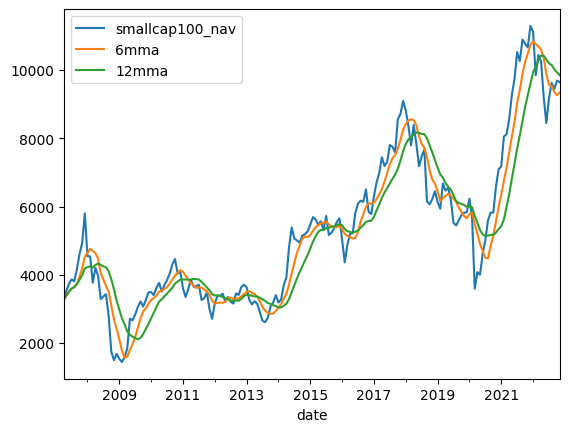

In [754]:
smallcap_100.plot()

In [755]:
df = smallcap_100.copy()
df['goldbees_nav'] = goldbees['goldbees_nav']

In [756]:
# Normalizing
df['goldbees_amounts'] = goldbees['goldbees_nav'] * 10000 / 9.22
df['smallcap_100_amounts'] = smallcap_100['smallcap100_nav'] * 10000 / 3263.90

In [765]:
in_smallcap_stock = False
in_goldbees = False
is_first = True
initial_amount = 10000
amounts = []
print("All buy and sell calls")
for date, row in df.T.items():
    if not in_smallcap_stock:
        if row['6mma'] >= row['12mma']:
            in_smallcap_stock = True
            in_goldbees = False
            print("Switched to smallcap stock @ {}".format(date.strftime('%Y-%m-%d')))
    if not in_goldbees:
        if not row['6mma'] >=  row['12mma']:
            in_smallcap_stock = False
            in_goldbees = True
            print("Switched to goldbees       @ {}".format(date.strftime('%Y-%m-%d')))
    if is_first:
        prev_row = row
        is_first = False
    if not in_goldbees:
        initial_amount = row['smallcap100_nav'] / prev_row['smallcap100_nav'] * initial_amount
    else:
        initial_amount = row['goldbees_nav'] / prev_row['goldbees_nav'] * initial_amount
    amounts.append(initial_amount)
    prev_row = row


All buy and sell calls
Switched to smallcap stock @ 2007-04-01
Switched to goldbees       @ 2008-06-01
Switched to smallcap stock @ 2009-07-01
Switched to goldbees       @ 2011-03-01
Switched to smallcap stock @ 2012-06-01
Switched to goldbees       @ 2013-05-01
Switched to smallcap stock @ 2014-02-01
Switched to goldbees       @ 2015-10-01
Switched to smallcap stock @ 2016-08-01
Switched to goldbees       @ 2018-06-01
Switched to smallcap stock @ 2020-11-01
Switched to goldbees       @ 2022-05-01


In [758]:
df['amounts'] = amounts

In [759]:
# calculate rolling returns of
# goldbees/nifty/smallcap
# 1 year/3 year/5 year/ 7 year

final_amounts = df[["amounts", 'smallcap_100_amounts', 'goldbees_amounts']]
strategies = ['smallcap_gold_timing', 'smallcap100', 'goldbees']
final_amounts.columns = strategies

<AxesSubplot: xlabel='date'>

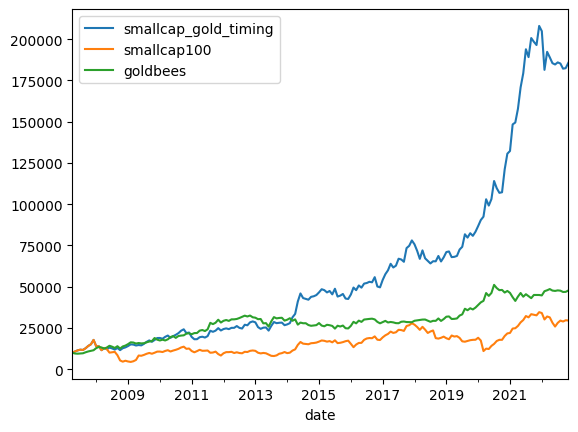

In [760]:
final_amounts.plot()

In [761]:
rolling_return_periods = [1,3,5,7]
types_of_returns = []

for strategy in strategies:
    for rolling_return_period in rolling_return_periods:
        back_period = "{}".format(strategy) + "_{}_year_lag".format(rolling_return_period)
        final_amounts[back_period] = final_amounts[strategy].shift(rolling_return_period*12)
        rolling_return_key = strategy + "_{}_year_rolling_returns".format(rolling_return_period)
        final_amounts[rolling_return_key] =  (final_amounts[strategy].div(final_amounts[back_period]).pow(1/rolling_return_period) - 1) * 100

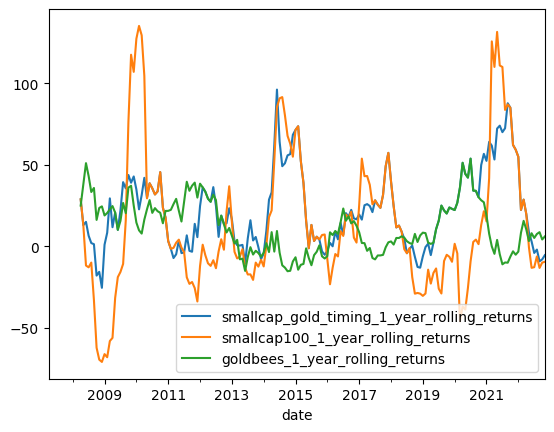

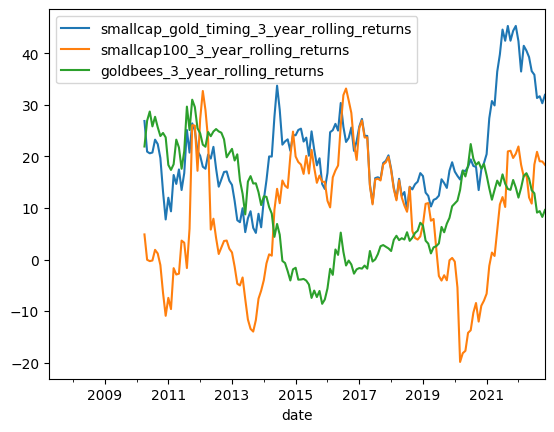

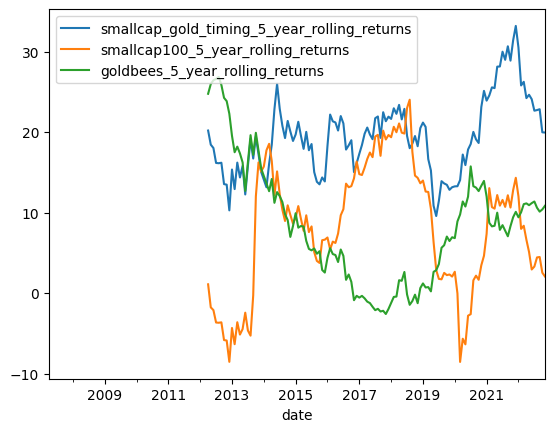

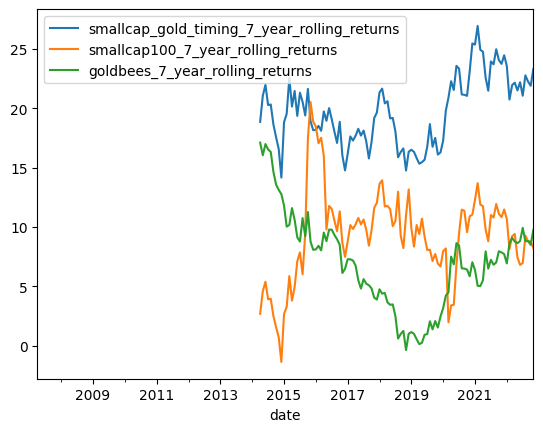

In [764]:
for rolling_return_period in rolling_return_periods:
    plot_line = ["{}_{}_year_rolling_returns".format(x, rolling_return_period) for x in strategies]
    final_amounts.plot(y=plot_line)
    